<a href="https://colab.research.google.com/github/Justin-Jonany/IndoFoodNet/blob/main/4_model_training_efficientnetv2_b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoFoodNet
IndoFoodNet aims to create a neural networks model that correctly classifies images of 9 differet Padang food. The dataset is taken from https://www.kaggle.com/datasets/faldoae/padangfood.

</br>

This notebook aims to create models to classify images into the correct labels based on **EfficientNetV2B2**

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import os

## Helper Functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()



def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Load Data

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/processed_data/b2_'
train_data = tf.data.Dataset.load(path + 'train_data')
test_data = tf.data.Dataset.load(path + 'test_data')
val_data = tf.data.Dataset.load(path + 'val_data')

In [ ]:
train_data.element_spec

(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/splitted_data/train/'
class_names = os.listdir(train_dir)

## Creating Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=4)

# Set checkpoint path
checkpoint_path = 'checkpoints/checkpoint'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch', # Save every epoch
                                                         verbose=1)



## Setup mixed prevision training

In [ ]:
# Turn on mixed prevision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Base Model

In [ ]:
input_shape = (260, 260, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

metrics = [tf.keras.metrics.F1Score(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           'accuracy'
          ]

In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_0 = tf.keras.Model(inputs, outputs)


# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics
                )

In [ ]:
history_0 = model_0.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/50
21/21 [==============================] - 29s 377ms/step - loss: 1.7258 - f1_score: 0.4788 - precision_1: 1.0000 - recall_1: 0.0077 - accuracy: 0.4738 - val_loss: 1.2687 - val_f1_score: 0.7727 - val_precision_1: 1.0000 - val_recall_1: 0.0556 - val_accuracy: 0.7778
Epoch 2/50
21/21 [==============================] - 2s 76ms/step - loss: 0.9702 - f1_score: 0.8492 - precision_1: 0.9946 - recall_1: 0.2840 - accuracy: 0.8519 - val_loss: 0.8453 - val_f1_score: 0.8545 - val_precision_1: 0.9762 - val_recall_1: 0.4556 - val_accuracy: 0.8556
Epoch 3/50
21/21 [==============================] - 2s 78ms/step - loss: 0.6501 - f1_score: 0.8976 - precision_1: 0.9808 - recall_1: 0.6312 - accuracy: 0.8981 - val_loss: 0.6561 - val_f1_score: 0.8680 - val_precision_1: 0.9831 - val_recall_1: 0.6444 - val_accuracy: 0.8667
Epoch 4/50
21/21 [==============================] - 3s 120ms/step - loss: 0.4993 - f1_score: 0.9212 - precision_1: 0.9747 - recall_1: 0.7716 - accuracy: 0.9213 - val_loss: 0.5546 

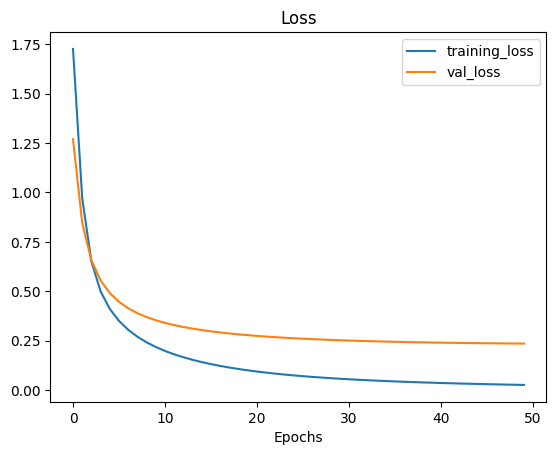

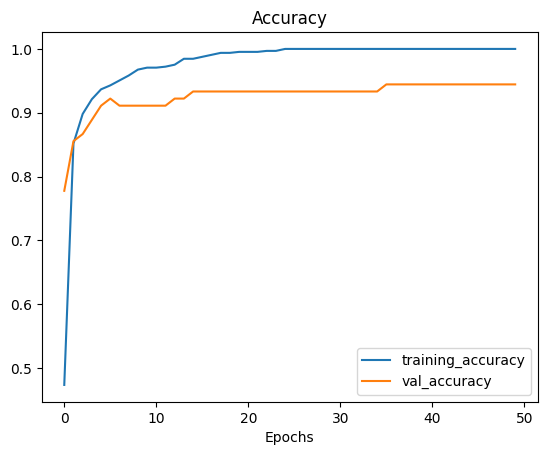

In [ ]:
plot_loss_curves(history_0)

It seems our model is overfitting

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 93ms/step - loss: 0.2355 - f1_score: 0.9442 - precision_1: 0.9647 - recall_1: 0.9111 - accuracy: 0.9444


[0.23548682034015656,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.9473684 , 1.        , 1.        ], dtype=float32),
 0.9647058844566345,
 0.9111111164093018,
 0.9444444179534912]

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_0')

## Model 1: Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name='data_augmentation')

In [ ]:
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics,
                )

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/50
21/21 [==============================] - 16s 196ms/step - loss: 1.7306 - f1_score: 0.5351 - precision_1: 0.9651 - recall_1: 0.1125 - accuracy: 0.4815 - val_loss: 1.2811 - val_f1_score: 0.7257 - val_precision_1: 1.0000 - val_recall_1: 0.0778 - val_accuracy: 0.7333
Epoch 2/50
21/21 [==============================] - 2s 81ms/step - loss: 0.9752 - f1_score: 0.8372 - precision_1: 0.9891 - recall_1: 0.2809 - accuracy: 0.8395 - val_loss: 0.8527 - val_f1_score: 0.8482 - val_precision_1: 0.9756 - val_recall_1: 0.4444 - val_accuracy: 0.8444
Epoch 3/50
21/21 [==============================] - 2s 80ms/step - loss: 0.6515 - f1_score: 0.9057 - precision_1: 0.9831 - recall_1: 0.6296 - accuracy: 0.9059 - val_loss: 0.6620 - val_f1_score: 0.8795 - val_precision_1: 0.9672 - val_recall_1: 0.6556 - val_accuracy: 0.8778
Epoch 4/50
21/21 [==============================] - 2s 94ms/step - loss: 0.4996 - f1_score: 0.9167 - precision_1: 0.9782 - recall_1: 0.7608 - accuracy: 0.9167 - val_loss: 0.5585 -

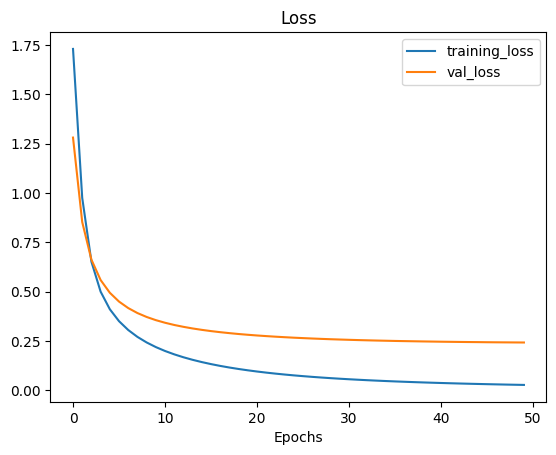

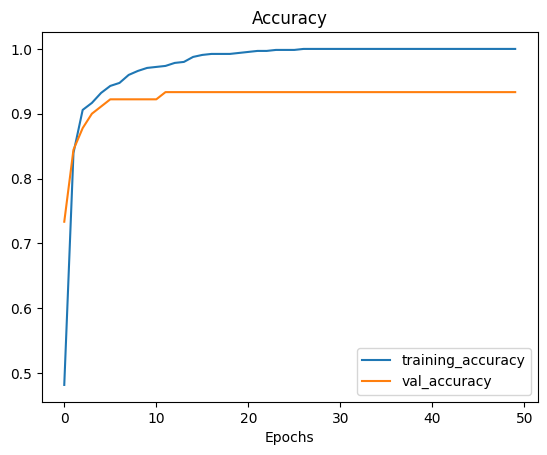

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.evaluate(val_data)

3/3 [==============================] - 0s 60ms/step - loss: 0.2418 - f1_score: 0.9325 - precision_1: 0.9432 - recall_1: 0.9222 - accuracy: 0.9333


[0.2418331801891327,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.84210527, 1.        , 1.        ], dtype=float32),
 0.9431818127632141,
 0.9222221970558167,
 0.9333333373069763]

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 59ms/step - loss: 0.2355 - f1_score: 0.9442 - precision_1: 0.9647 - recall_1: 0.9111 - accuracy: 0.9444


[0.23548682034015656,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.9473684 , 1.        , 1.        ], dtype=float32),
 0.9647058844566345,
 0.9111111164093018,
 0.9444444179534912]

It seems that data augmentation doesn't imrpove our model. hmmmmmm

In [ ]:
model_1.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_1')

## Model 2: Fine Tuning on the base model with no data augmentation


Let's unfreeze the first 10 layers for this model

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_0')

In [ ]:
model_2.layers

In [ ]:
model_2.layers[1].trainable = True
for layer in model_2.layers[1].layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=metrics)

In [ ]:
fine_tune_epochs = history_0.epoch[-1] + 50
checkpoint_callback.filepath = 'checkpoint/model_2'
history_2 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[early_stopping,
                                   checkpoint_callback]
                        )

Epoch 50/99
20/21 [===========================>..] - ETA: 0s - loss: 0.0205 - f1_score: 0.9918 - precision_1: 0.9945 - recall_1: 0.9877 - accuracy: 0.9984
Epoch 50: val_loss improved from inf to 0.23435, saving model to checkpoint/model_2
21/21 [==============================] - 18s 296ms/step - loss: 0.0203 - f1_score: 0.9919 - precision_1: 0.9945 - recall_1: 0.9878 - accuracy: 0.9985 - val_loss: 0.2343 - val_f1_score: 0.9446 - val_precision_1: 0.9545 - val_recall_1: 0.9333 - val_accuracy: 0.9444
Epoch 51/99
20/21 [===========================>..] - ETA: 0s - loss: 0.0098 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000
Epoch 51: val_loss did not improve from 0.23435
21/21 [==============================] - 2s 86ms/step - loss: 0.0098 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000 - val_loss: 0.2644 - val_f1_score: 0.9329 - val_precision_1: 0.9326 - val_recall_1: 0.9222 - val_accuracy: 0.9333
Epoch 52/99
20/21 [=============

In [ ]:
model_2.evaluate(val_data)

3/3 [==============================] - 0s 58ms/step - loss: 0.2794 - f1_score: 0.9331 - precision_1: 0.9545 - recall_1: 0.9333 - accuracy: 0.9333


[0.27944260835647583,
 array([0.84210527, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.9       , 0.9473684 , 1.        , 1.        ], dtype=float32),
 0.9545454382896423,
 0.9333333373069763,
 0.9333333373069763]

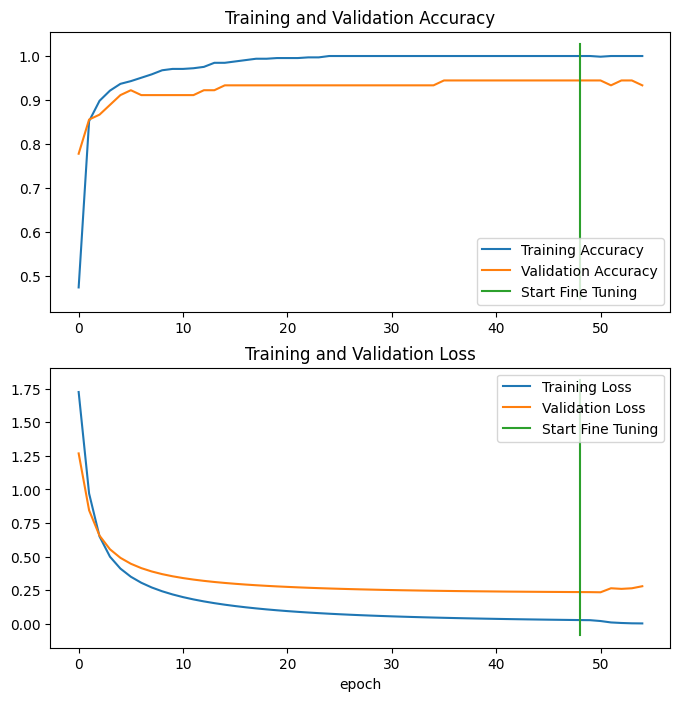

In [ ]:
compare_historys(history_0, history_2, history_0.epoch[-1])

In [ ]:
model_2.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_2')

Hmmmm, it seems model_2 is not making it better

## Model 3: Model 2 but less learning rate

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_0')

In [ ]:
model_3.layers[1].trainable = True
for layer in model_3.layers[1].layers[:-10]:
  layer.trainable = False

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=metrics)

In [ ]:
fine_tune_epochs = history_0.epoch[-1] + 50

checkpoint_callback.filepath = 'checkpoint/model_3'

history_3 = model_3.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[early_stopping, checkpoint_callback]
                        )

Epoch 50/99
20/21 [===========================>..] - ETA: 0s - loss: 0.0249 - f1_score: 0.9918 - precision_1: 0.9945 - recall_1: 0.9918 - accuracy: 1.0000
Epoch 50: val_loss did not improve from 0.23435
21/21 [==============================] - 16s 217ms/step - loss: 0.0247 - f1_score: 0.9919 - precision_1: 0.9946 - recall_1: 0.9919 - accuracy: 1.0000 - val_loss: 0.2357 - val_f1_score: 0.9442 - val_precision_1: 0.9535 - val_recall_1: 0.9111 - val_accuracy: 0.9444
Epoch 51/99
20/21 [===========================>..] - ETA: 0s - loss: 0.0212 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000
Epoch 51: val_loss improved from 0.23435 to 0.23406, saving model to checkpoint/model_3
21/21 [==============================] - 2s 116ms/step - loss: 0.0211 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000 - val_loss: 0.2341 - val_f1_score: 0.9329 - val_precision_1: 0.9651 - val_recall_1: 0.9222 - val_accuracy: 0.9333
Epoch 52/99
20/21 [========

In [ ]:
model_3.evaluate(val_data)

3/3 [==============================] - 0s 78ms/step - loss: 0.2372 - f1_score: 0.9442 - precision_1: 0.9545 - recall_1: 0.9333 - accuracy: 0.9444


[0.2372075617313385,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.9473684 , 1.        , 1.        ], dtype=float32),
 0.9545454382896423,
 0.9333333373069763,
 0.9444444179534912]

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 76ms/step - loss: 0.2355 - f1_score: 0.9442 - precision_1: 0.9647 - recall_1: 0.9111 - accuracy: 0.9444


[0.23548682034015656,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.9473684 , 1.        , 1.        ], dtype=float32),
 0.9647058844566345,
 0.9111111164093018,
 0.9444444179534912]

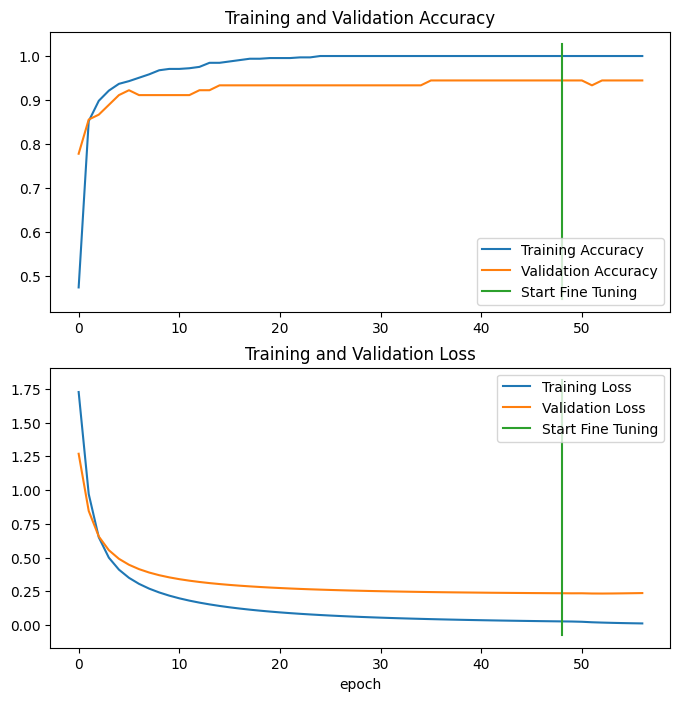

In [ ]:
compare_historys(history_0, history_3, history_0.epoch[-1])

In [ ]:
model_3.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_3')

Hmmmm it seems model_3 is not doing well, looks like our base model performs best

## Model 4: Just the base model but with more epochs

In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_4 = tf.keras.Model(inputs, outputs)


# Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics
                )

In [ ]:
history_4 = model_4.fit(train_data,
                        epochs=200,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping,
                                   checkpoint_callback]
                        )

Epoch 1/200
20/21 [===========================>..] - ETA: 0s - loss: 1.8084 - f1_score: 0.5078 - precision_1: 0.9667 - recall_1: 0.1192 - accuracy: 0.4422
Epoch 1: val_loss did not improve from 0.23373
21/21 [==============================] - 15s 216ms/step - loss: 1.8026 - f1_score: 0.5121 - precision_1: 0.9667 - recall_1: 0.1179 - accuracy: 0.4475 - val_loss: 1.3110 - val_f1_score: 0.7548 - val_precision_1: 1.0000 - val_recall_1: 0.0444 - val_accuracy: 0.7667
Epoch 2/200
20/21 [===========================>..] - ETA: 0s - loss: 1.0216 - f1_score: 0.8080 - precision_1: 0.9882 - recall_1: 0.2625 - accuracy: 0.8109
Epoch 2: val_loss did not improve from 0.23373
21/21 [==============================] - 3s 119ms/step - loss: 1.0172 - f1_score: 0.8109 - precision_1: 0.9886 - recall_1: 0.2670 - accuracy: 0.8133 - val_loss: 0.8683 - val_f1_score: 0.8561 - val_precision_1: 0.9756 - val_recall_1: 0.4444 - val_accuracy: 0.8556
Epoch 3/200
20/21 [===========================>..] - ETA: 0s - loss: 

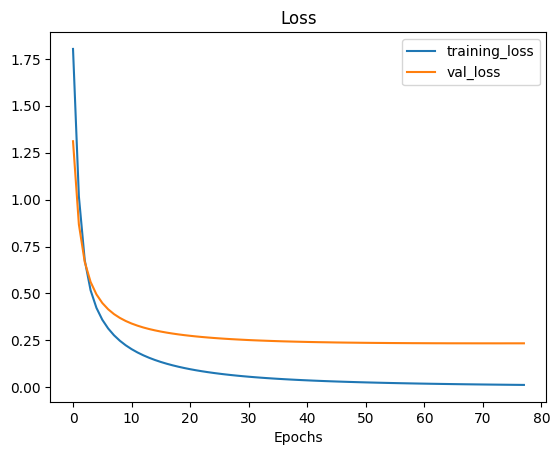

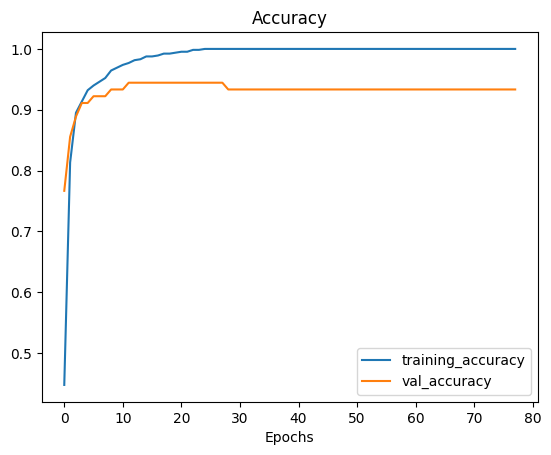

In [ ]:
plot_loss_curves(history_4)

In [ ]:
model_4.evaluate(val_data)

3/3 [==============================] - 0s 64ms/step - loss: 0.2346 - f1_score: 0.9325 - precision_1: 0.9545 - recall_1: 0.9333 - accuracy: 0.9333


[0.2345815896987915,
 array([0.88888896, 0.9       , 0.95238096, 0.9473684 , 0.90909094,
        0.95238096, 0.84210527, 1.        , 1.        ], dtype=float32),
 0.9545454382896423,
 0.9333333373069763,
 0.9333333373069763]

In [ ]:
model_4.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b2/model_4')

we will conclude this notebook on model training on **EfficientNetV2B2**

In [ ]:
model_0_scores = model_0.evaluate(val_data)
model_1_scores = model_1.evaluate(val_data)
model_2_scores = model_2.evaluate(val_data)
model_3_scores = model_3.evaluate(val_data)
model_4_scores = model_4.evaluate(val_data)

3/3 [==============================] - 0s 60ms/step - loss: 0.2346 - f1_score: 0.9325 - precision_1: 0.9545 - recall_1: 0.9333 - accuracy: 0.9333


In [ ]:
print(f'model_0:\n loss: {model_0_scores[0]} \n accuracy: {model_0_scores[4]}')
print(f'model_1:\n loss: {model_1_scores[0]} \n accuracy: {model_1_scores[4]}')
print(f'model_2:\n loss: {model_2_scores[0]} \n accuracy: {model_2_scores[4]}')
print(f'model_3:\n loss: {model_3_scores[0]} \n accuracy: {model_3_scores[4]}')
print(f'model_4:\n loss: {model_4_scores[0]} \n accuracy: {model_4_scores[4]}')


model_0:
 loss: 0.23548682034015656 
 accuracy: 0.9444444179534912
model_1:
 loss: 0.2418331801891327 
 accuracy: 0.9333333373069763
model_2:
 loss: 0.27944260835647583 
 accuracy: 0.9333333373069763
model_3:
 loss: 0.2372075617313385 
 accuracy: 0.9444444179534912
model_4:
 loss: 0.2345815896987915 
 accuracy: 0.9333333373069763


In [ ]:
model_0_scores[1] = model_0_scores[1].mean()
model_1_scores[1] = model_1_scores[1].mean()
model_2_scores[1] = model_2_scores[1].mean()
model_3_scores[1] = model_3_scores[1].mean()
model_4_scores[1] = model_4_scores[1].mean()

loss = pd.DataFrame({'model_0': model_0_scores,
                         'model_1': model_1_scores,
                         'model_2': model_2_scores,
                         'model_3': model_3_scores,
                         'model_4': model_4_scores,
                         }, index=['loss', 'f1-score', 'precision', 'recall', 'accuracy'])
loss = loss.T
loss

,loss,f1-score,precision,recall,accuracy
model_0,0.235487,0.944164,0.964706,0.911111,0.944444
model_1,0.241833,0.932468,0.943182,0.922222,0.933333
model_2,0.279443,0.933146,0.954545,0.933333,0.933333
model_3,0.237208,0.944164,0.954545,0.933333,0.944444
model_4,0.234582,0.932468,0.954545,0.933333,0.933333


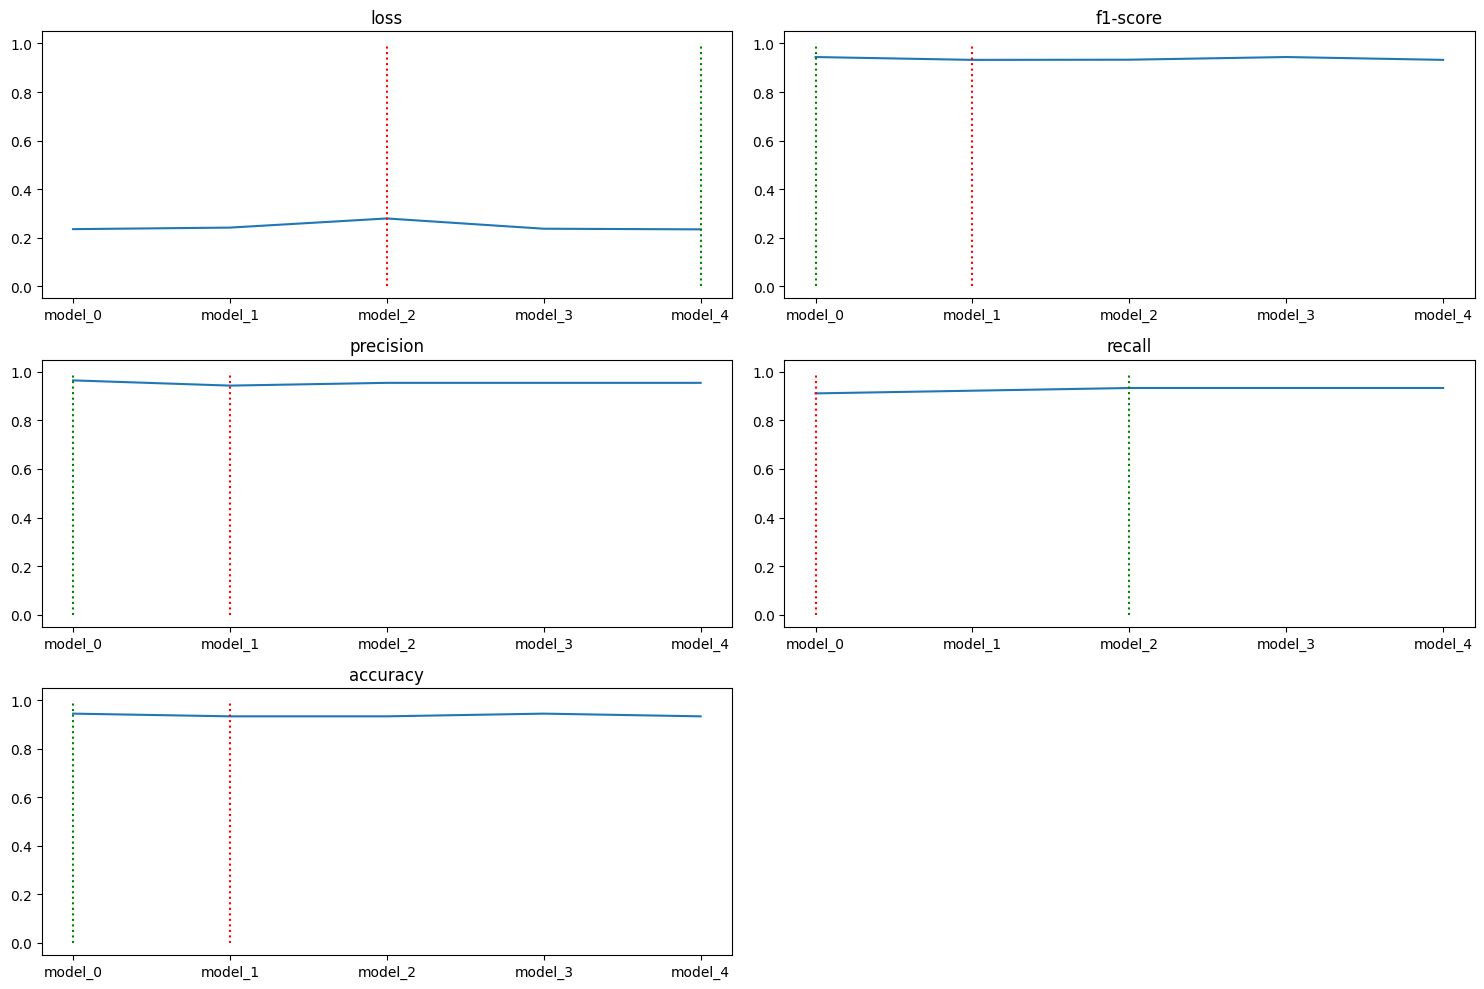

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, index in enumerate(loss.columns):
  plt.subplot(3, 2, 1 + i)
  plt.plot(loss[index])
  plt.title(index)
  if index == 'loss':
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='red', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='green', linestyles='dotted')
  else:
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='red', linestyles='dotted')

fig.tight_layout()

It seems that the results are very similar, but the model with lowest loss is model 4

In [ ]:
model_4.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/best_model_per_version/efficientnetv2b2_fine_tuned')